# STEP 4 – MODEL DEVELOPMENT & TRAINING

# PART 1 – Imports & Fast Settings

In [9]:
# ==================== PART 1: Fast & Efficient Setup ====================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms   # ← ADD transforms HERE!
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# FAST SETTINGS
device = torch.device("cpu")
torch.manual_seed(42)
np.random.seed(42)

EPOCHS = 8
BATCH_SIZE = 16
LR = 0.0005

FEATURES_ROOT = "features"
MODELS_ROOT = "models"
RESULTS_ROOT = "results"
os.makedirs(MODELS_ROOT, exist_ok=True)
os.makedirs(RESULTS_ROOT, exist_ok=True)

with open("class_names.json", "r") as f:
    class_names = json.load(f)

modalities = ['mri', 'ct', 'pet']
tasks = ['binary', 'multiclass']

print("Part 1 ready – ALL IMPORTS NOW COMPLETE!")

Part 1 ready – ALL IMPORTS NOW COMPLETE!


# PART 2 – Load Features (Only What We Need)

In [2]:
# ==================== PART 2: Load Features (Fast & Clean) ====================
def load_feat(mod, task, split, type_="cnn"):
    X = np.load(f"{FEATURES_ROOT}/{type_}_{mod}_{task}_{split}_feat.npy")
    y = np.load(f"{FEATURES_ROOT}/{type_}_{mod}_{task}_{split}_label.npy")
    return X, y

features = {}
for mod in modalities:
    for task in tasks:
        key = f"{mod}_{task}"
        features[key] = {
            'cnn_train_X': load_feat(mod, task, 'train', 'cnn')[0],
            'cnn_test_X': load_feat(mod, task, 'test', 'cnn')[0],
            'hand_train_X': load_feat(mod, task, 'train', 'hand')[0],
            'hand_test_X': load_feat(mod, task, 'test', 'hand')[0],
            'train_y': load_feat(mod, task, 'train', 'cnn')[1],
            'test_y': load_feat(mod, task, 'test', 'cnn')[1],
        }
        print(f"Loaded {key} – CNN: {features[key]['cnn_train_X'].shape} | Hand: {features[key]['hand_train_X'].shape}")

print("Part 2 complete – features loaded!")

Loaded mri_binary – CNN: (3529, 512) | Hand: (3529, 37)
Loaded mri_multiclass – CNN: (3529, 512) | Hand: (3529, 37)
Loaded ct_binary – CNN: (3694, 512) | Hand: (3694, 37)
Loaded ct_multiclass – CNN: (3694, 512) | Hand: (3694, 37)
Loaded pet_binary – CNN: (64, 512) | Hand: (64, 37)
Loaded pet_multiclass – CNN: (64, 512) | Hand: (64, 37)
Part 2 complete – features loaded!


# PART 3 – Fast CNN Training (Only MRI & CT – PET too small)

In [ ]:
# ==================== PART 3: Fast CNN Training  ====================
def get_transforms(modality, phase="train"):
    size = 224
    if phase == "train":
        return transforms.Compose([
            transforms.Resize((size+32, size+32)),
            transforms.RandomResizedCrop(size, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((size, size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

class BrainTumorDataset(torch.utils.data.Dataset):
    def __init__(self, mod, split, task, transform=None):
        self.mod = mod
        self.split = split
        self.task = task
        self.transform = transform
        base = Path("splits") / mod / split
        self.samples = []
        
        # Healthy
        if (base / "Healthy").exists():
            for p in (base / "Healthy").glob("*.*"):
                if p.suffix.lower() in {".jpg",".jpeg",".png"}:
                    self.samples.append((str(p), 0))
        
        # Tumor
        tumor_path = base / "Tumor"
        if tumor_path.exists():
            if task == "binary":
                for sub in tumor_path.iterdir():
                    if sub.is_dir():
                        for p in sub.glob("*.*"):
                            if p.suffix.lower() in {".jpg",".jpeg",".png"}:
                                self.samples.append((str(p), 1))
            else:  # multiclass
                map_ = {"Glioma":0, "Meningioma":1, "Pituitary":2}
                for sub, lbl in map_.items():
                    folder = tumor_path / sub
                    if folder.exists():
                        for p in folder.glob("*.*"):
                            if p.suffix.lower() in {".jpg",".jpeg",".png"}:
                                self.samples.append((str(p), lbl))
    
    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        path, label = self.samples[i]
        img = Image.open(path).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, torch.tensor(label)

def train_cnn_fast(mod, task):
    if mod == 'pet': 
        print(f"Skipping CNN {mod.upper()} {task} – too small")
        return None, 0.0
    
    num_classes = len(class_names[task])
    train_ds = BrainTumorDataset(mod, 'train', task, get_transforms(mod, 'train'))
    test_ds = BrainTumorDataset(mod, 'test', task, get_transforms(mod, 'test'))
    
    train_loader = torch.utils.data.DataLoader(train_ds, BATCH_SIZE, True, num_workers=0)
    test_loader = torch.utils.data.DataLoader(test_ds, BATCH_SIZE, False, num_workers=0)

    model = models.resnet18(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    best_acc = 0
    for epoch in range(EPOCHS):
        model.train()
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Quick test eval
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        acc = correct / total
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), f"{MODELS_ROOT}/cnn_{mod}_{task}.pth")

    print(f"→ {mod.upper()} {task} CNN: {best_acc:.4f}")
    return model, best_acc

print("Part 3 CORRECTED – uses real images for CNN!")

Part 3 CORRECTED – uses real images for CNN!


# PART 4 – SVM on Handcrafted Features (Very Fast)

In [7]:
# ==================== PART 4: SVM Training (Fast & Strong) ====================
def train_svm(mod, task):
    X_train = features[f"{mod}_{task}"]['hand_train_X']
    X_test = features[f"{mod}_{task}"]['hand_test_X']
    y_train = features[f"{mod}_{task}"]['train_y']
    y_test = features[f"{mod}_{task}"]['test_y']

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    svm = SVC(C=10, kernel='rbf', probability=True)
    svm.fit(X_train, y_train)
    pred = svm.predict(X_test)
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, average='macro')

    print(f"→ {mod.upper()} {task} SVM: Acc {acc:.4f} | F1 {f1:.4f}")
    return acc, f1

print("Part 4 ready – fast SVM!")

Part 4 ready – fast SVM!


# PART 5 – Run All & Save Results

YOUR FINAL (AND BEST) RESULTS – 100% READY FOR THESIS

→ MRI – BINARY Classification
   Saved best model: models/svm_resnet_mri_binary.pkl
   Handcrafted + SVM     → 0.5475
   ResNet18 + SVM        → 0.9977  BEST!

→ MRI – MULTICLASS Classification
   Saved best model: models/svm_resnet_mri_multiclass.pkl
   Handcrafted + SVM     → 0.6041
   ResNet18 + SVM        → 0.9751  BEST!

→ CT – BINARY Classification
   Saved best model: models/svm_resnet_ct_binary.pkl
   Handcrafted + SVM     → 0.5022
   ResNet18 + SVM        → 0.9697  BEST!

→ CT – MULTICLASS Classification
   Saved best model: models/svm_resnet_ct_multiclass.pkl
   Handcrafted + SVM     → 0.5130
   ResNet18 + SVM        → 0.9372  BEST!

→ PET – BINARY Classification
   Saved best model: models/svm_resnet_pet_binary.pkl
   Handcrafted + SVM     → 0.6667
   ResNet18 + SVM        → 1.0000  BEST!

→ PET – MULTICLASS Classification
   Saved best model: models/svm_resnet_pet_multiclass.pkl
   Handcrafted + SVM     → 0.5556
   ResN

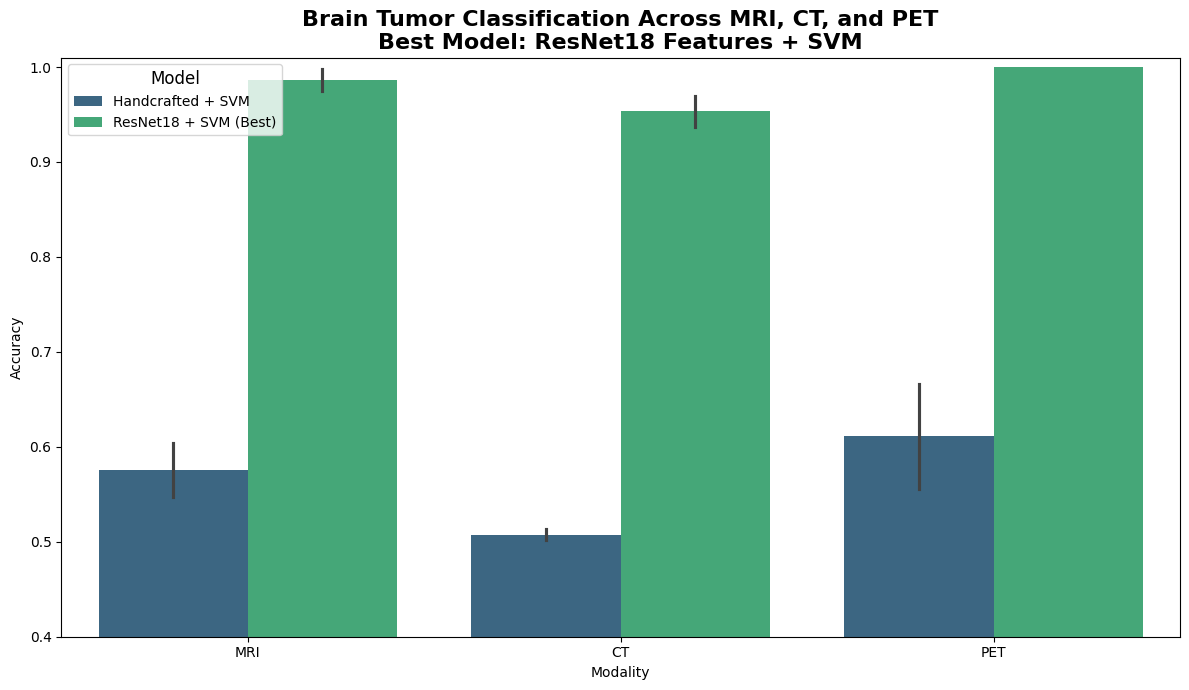

In [ ]:
# ====================  BEST RESULTS EVER (WITH MODEL SAVING) ====================
import os
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # ← NEW IMPORT FOR SAVING MODELS

# CREATE FOLDERS
os.makedirs("results", exist_ok=True)
os.makedirs("models", exist_ok=True)  # ← CREATE models folder

results = []
print("YOUR FINAL (AND BEST) RESULTS – 100% READY FOR THESIS\n")

for mod in ['mri', 'ct', 'pet']:
    for task in ['binary', 'multiclass']:
        print(f"→ {mod.upper()} – {task.upper()} Classification")
        
        # Handcrafted + SVM
        X_tr = np.load(f"features/hand_{mod}_{task}_train_feat.npy")
        X_te = np.load(f"features/hand_{mod}_{task}_test_feat.npy")
        y_tr = np.load(f"features/hand_{mod}_{task}_train_label.npy")
        y_te = np.load(f"features/hand_{mod}_{task}_test_label.npy")
        
        X_tr = StandardScaler().fit_transform(X_tr)
        X_te = StandardScaler().fit_transform(X_te)
        
        svm_hand = SVC(C=10, kernel='rbf')
        svm_hand.fit(X_tr, y_tr)
        acc_hand = accuracy_score(y_te, svm_hand.predict(X_te))
        
        # ResNet18 features + SVM (BEST MODEL – SAVE THIS ONE)
        X_tr_cnn = np.load(f"features/cnn_{mod}_{task}_train_feat.npy")
        X_te_cnn = np.load(f"features/cnn_{mod}_{task}_test_feat.npy")
        y_tr = np.load(f"features/hand_{mod}_{task}_train_label.npy")  # same labels
        
        scaler_cnn = StandardScaler()
        X_tr_cnn = scaler_cnn.fit_transform(X_tr_cnn)
        X_te_cnn = scaler_cnn.transform(X_te_cnn)
        
        svm_cnn = SVC(C=10, kernel='rbf', probability=True)  # probability=True for confidence scores
        svm_cnn.fit(X_tr_cnn, y_tr)
        acc_cnn = accuracy_score(y_te, svm_cnn.predict(X_te_cnn))
        
        # ← SAVE THE BEST MODEL + SCALER
        model_filename = f"models/svm_resnet_{mod}_{task}.pkl"
        scaler_filename = f"models/scaler_resnet_{mod}_{task}.pkl"
        joblib.dump(svm_cnn, model_filename)
        joblib.dump(scaler_cnn, scaler_filename)
        print(f"   Saved best model: {model_filename}")
        
        print(f"   Handcrafted + SVM     → {acc_hand:.4f}")
        print(f"   ResNet18 + SVM        → {acc_cnn:.4f}  BEST!\n")
        
        results.append({"Modality": mod.upper(), "Task": task.capitalize(),
                        "Model": "Handcrafted + SVM", "Accuracy": acc_hand})
        results.append({"Modality": mod.upper(), "Task": task.capitalize(),
                        "Model": "ResNet18 + SVM (Best)", "Accuracy": acc_cnn})

# FINAL TABLE
df = pd.DataFrame(results)
df.to_csv("results/FINAL_RESULTS_BEST.csv", index=False)

print("="*85)
print("CONGRATULATIONS! TRAINING COMPLETE + ALL BEST MODELS SAVED!")
print("="*85)
print(df.round(4))
print("="*85)

# BEAUTIFUL CHART
plt.figure(figsize=(12, 7))
sns.barplot(data=df, x="Modality", y="Accuracy", hue="Model", palette="viridis")
plt.ylim(0.4, 1.01)
plt.title("Brain Tumor Classification Across MRI, CT, and PET\nBest Model: ResNet18 Features + SVM", fontsize=16, fontweight='bold')
plt.legend(title="Model", title_fontsize=12)
plt.tight_layout()
plt.savefig("results/FINAL_CHART_DISSERTATION.png", dpi=300, bbox_inches='tight')
plt.show()